# ![title](imagens/title_IAP_ALA.png)

**AUTORES:**
- Ian Mascaro Salomão - DRE: *123162270*
- Vinícius Leoni Gonçalves - DRE: *121083446*

# **BEM-VINDO, TREINADOR!**  
***  
Este é o **Gerador de Índice de Afinidade Pokémon (IAP)**!  

O objetivo desta ferramenta é ajudar treinadores a identificar os Pokémon cujos status base são mais semelhantes ao de seu Pokémon de interesse. O cálculo leva em conta tanto a **distribuição dos valores entre os diferentes atributos** quanto a **magnitude absoluta de cada um**, garantindo uma análise detalhada, estratégica e precisa.  

## **APLICAÇÕES PRÁTICAS**  
- **Reforçando sua jornada:** Se você perdeu um de seus companheiros ao longo da jornada por Kanto, o Gerador de IAP encontra espécies com perfis semelhantes, permitindo que você continue batalhando sem perder a essência do seu time.  
- **Vantagem tática em ginásios:** Substitua Pokémon com desvantagens de tipo por companheiros mais adequados, mantendo equilíbrio e competitividade nas batalhas.  
- **Planejamento estratégico:** Ideal para montar equipes focadas em características específicas, como alta ou baixa velocidade, golpes físicos ou especiais, e até mesmo balancear sua composição geral de equipe.  




# **Instalando os Pacotes Necessários**  
***  
Antes de utilizar este notebook, certifique-se de que **Julia** e **Jupyter Notebook** estão instalados e configurados corretamente em sua máquina. Caso ainda não tenha instalado, consulte a documentação oficial para garantir a instalação adequada:  

- [Julia Downloads](https://julialang.org/downloads/)  
- [Jupyter Notebook](https://jupyter.org/install)  


**Importante:** Execute o bloco de código a seguir **apenas uma vez** para instalar os pacotes em seu ambiente Julia.  


In [ ]:
#Execute este bloco de código apenas uma vez
#Galo!!!
#FLU!!!
using Pkg

Pkg.add("HTTP")
Pkg.add("JSON")
Pkg.add("LinearAlgebra")
Pkg.add("IJulia")
Pkg.add("PlotlyJS")

## Usando a PokeAPI
***
Vamos aprender a utilizar a PokeAPI. Essa API contém as informações de todos os Pokemóns. Para o nosso projeto, usaremos apenas a 1° Geração. 
Vamos extrair os nomes e status base dos Pokémons para poder gerar a métrica criada por nós; o **Índice de Afinidade Pokémon (IAP)**.

No exemplo abaixo, extraímos os dados dos Pokémons Scyther e Dodrio, utilizando as urls diretamente por seus nomes.

Também entendemos como devem ser trataras as informações de cadeia evolutiva e como extrair uma lista com o nome de todos os pokémons de uma cadeia evolutiva


In [1]:
using HTTP, JSON
#Entendendo como pegar a cadeia evolutiva
url = "https://pokeapi.co/api/v2/pokemon-species/1/"  
response = HTTP.get(url)
data = JSON.parse(String(response.body))
evolution_chain_id = data["evolution_chain"]["url"]
responde_4 = HTTP.get(evolution_chain_id)
data_4 = JSON.parse(String(responde_4.body))

println(responde_4["chain"])



In [2]:
using HTTP
using JSON
#entendendo como pegar os nomes dos pokemons dentro da cadeia evolutiva
function get_evolution_names(pokemon_ID::Int)
    # Obtém os dados da espécie do Pokémon
    url = "https://pokeapi.co/api/v2/pokemon-species/$pokemon_ID/"
    response = HTTP.get(url)
    data = JSON.parse(String(response.body))
    
    # URL da cadeia de evolução
    evolution_chain_url = data["evolution_chain"]["url"]
    response_chain = HTTP.get(evolution_chain_url)
    data_chain = JSON.parse(String(response_chain.body))
    chain = data_chain["chain"]

    # Função auxiliar para percorrer a cadeia de evolução de forma recursiva
    function parse_chain(chain_node)
        names = [chain_node["species"]["name"]]
        for evolution in chain_node["evolves_to"]
            append!(names, parse_chain(evolution))
        end
        return names
    end

    # Processa a cadeia de evolução
    return parse_chain(chain)
end

println("Cadeia de evolução: ")
println(get_evolution_names(10)) # Teste com o Pokémon Bulbasaur (ID = 1)


Cadeia de evolução: 
["caterpie", "metapod", "butterfree"]


In [3]:
#Usando a PokeAPI 
using HTTP, JSON

# URL da PokeAPI para buscar dados do scyther
url = "https://pokeapi.co/api/v2/pokemon/scyther"
# URL DA PokeAPI para buscar dados do dodrio
url2 = "https://pokeapi.co/api/v2/pokemon/dodrio"

# Fazer a requisição GET
response = HTTP.get(url)
response_2 = HTTP.get(url2)

# Parse do conteúdo JSON
data = JSON.parse(String(response.body))
data_2 = JSON.parse(String(response_2.body))

datas = [data, data_2]

# Exibir informações sobre scyther e dodrio
for x in datas
    println("Nome: ", x["name"])
    println("Altura: ", x["height"])
    println("Peso: ", x["weight"])
    println("Habilidades: ", [h["ability"]["name"] for h in x["abilities"]])

    for h in x["stats"]
        println("Status: ", h["stat"]["name"], " -> Valor Base: ", h["base_stat"])
    end
    
    
end

Nome: scyther
Altura: 15
Peso: 560
Habilidades: ["swarm", "technician", "steadfast"]
Status: hp -> Valor Base: 70
Status: attack -> Valor Base: 110
Status: defense -> Valor Base: 80
Status: special-attack -> Valor Base: 55
Status: special-defense -> Valor Base: 80
Status: speed -> Valor Base: 105
Nome: dodrio
Altura: 18
Peso: 852
Habilidades: ["run-away", "early-bird", "tangled-feet"]
Status: hp -> Valor Base: 60
Status: attack -> Valor Base: 110
Status: defense -> Valor Base: 70
Status: special-attack -> Valor Base: 60
Status: special-defense -> Valor Base: 60
Status: speed -> Valor Base: 110


# **Capturando os Status dos Pokémon da Primeira Geração via PokeAPI**  
***  
Neste universo de Pokémon, cada Pokémon possui 6 **status base**:   , que serão interpretados como vetores: $\begin{bmatrix} HP. \\ Atk. \\ Def. \\ Sp. Atk. \\ Sp. Def. \\ Speed\end{bmatrix} $. 

Para isso, criamos duas estruturas principais:  

- **`NAMES_VECTOR`**: Um vetor que armazena os nomes dos 151 Pokémon originais, ordenados pelo número do Pokédex.  
- **`STATS_MATRIX`**: Uma matriz onde cada coluna representa o vetor de status de um Pokémon, também ordenado pelo número do Pokédex.  

Com essa estrutura, acessar a posição $i$ do **`NAMES_VECTOR`** retorna o nome do Pokémon cujo vetor de status está na $i$-ésima coluna da **`STATS_MATRIX`**.  

## **A coleta de Dados via PokeAPI**  
Como a PokeAPI permite acessar dados de cada Pokémon usando seu número do Pokédex, e esse número varia de 1 a 151 para a primeira geração, a consulta se torna iterável, facilitando assim a criação das nossas estruturas principais.  

---

In [4]:
using HTTP, JSON

#Função para obter informações de um Pokémon por ID
function get_pokemon_data(id::Int)
    url = "https://pokeapi.co/api/v2/pokemon/$id"
    response = HTTP.get(url)
    data = JSON.parse(String(response.body))
    return data
end

function create_pokemon_stats_matrix(qt_pkmn::Int)
    matriz_stats = zeros(6, 0)  #Matriz com 6 linhas e 0 colunas
    vetor_nomes = String[] #Matriz com os nomes dos Pokémons
    
    
    for id in 1:qt_pkmn
        data = get_pokemon_data(id)
        nova_coluna = Int[]
        for h in data["stats"]
            push!(nova_coluna, h["base_stat"]) 
        end

        push!(vetor_nomes, data["name"]) 
        
        matriz_stats = hcat(matriz_stats, nova_coluna)
    end

    return matriz_stats , vetor_nomes
end

#Gerando os dados principais da análise
MOTHER_MATRIX = create_pokemon_stats_matrix(151)
STATS_MATRIX = MOTHER_MATRIX[1]
NAMES_VECTOR = MOTHER_MATRIX[2]



151-element Vector{String}:
 "bulbasaur"
 "ivysaur"
 "venusaur"
 "charmander"
 "charmeleon"
 "charizard"
 "squirtle"
 "wartortle"
 "blastoise"
 "caterpie"
 ⋮
 "snorlax"
 "articuno"
 "zapdos"
 "moltres"
 "dratini"
 "dragonair"
 "dragonite"
 "mewtwo"
 "mew"

# **Definindo Funções de Álgebra Linear**  
***  
Neste módulo, utilizamos conceitos fundamentais de **Álgebra Linear Algorítmica** para trabalhar com vetores e calcular o quão próximos dois vetores estão, usando duas métricas principais:  

1. **Distância Angular**  
2. **Distância Euclidiana**  

Além disso, introduzimos a normalização da Distância Euclidiana para ajustá-la ao intervalo $ [0, 1] $, tornando os valores mais interpretáveis em certos contextos.

---

## **1. Distância Angular**  

A **distância angular** entre dois vetores $ \vec{u} $ e $ \vec{v} $ é calculada usando o cosseno do ângulo $\theta$ entre eles. A fórmula é:  

$ D = | \cos(\theta) | = \left| \frac{<\vec{u},\vec{v}>}{∥\vec{u}∥ \cdot ∥\vec{v}∥} \right| $

Onde:  
- $ \vec{u} \cdot \vec{v} $ é o **produto interno** entre os vetores.  
- $ ∥\vec{u}∥ $ e $ ∥\vec{v}∥ $ são as **normas** dos vetores.  

---

## **2. Distância Euclidiana**  

A **distância euclidiana** entre dois vetores $ \vec{u} $ e $ \vec{v} $ mede a diferença absoluta entre eles e é dada pela norma do vetor $ \vec{u} - \vec{v} $:  


$ D = ∥\vec{u} - \vec{v}∥ $ 


---

## **3. Normalização da Distância Euclidiana**  

A **distância euclidiana normalizada** ajusta os valores para o intervalo $[0, 1]$, onde:  
- **1** representa vetores idênticos.  
- **0** representa vetores muito distantes.  

A fórmula é:  

$ N = \frac{1}{1 + ∥\vec{u} - \vec{v}∥} $

---




In [5]:
using LinearAlgebra

function cos_calc(v1, v2)
  #Calcula a distância angular entre vetores com base na fórmula do produto escalar de v1 e v2, dividido pelo produto das normas de v1 e v2
  return (dot(v1,v2)/(norm(v1)*norm(v2)))

end

function euclidian_dist(v1, v2)
  #Calculaa distância euclidiana combase na fórmula: ||v1-v2||
  return norm(v1-v2)
end

function normalize_euclidian_image(v1,v2)
  #Essa função trabalha a distância entre vetores e torna um valor entre 0 e 1, onde dará 0 para distancias grandes, e 1 para pequenas distâncias
  return 1 / (1+euclidian_dist(v1,v2))
end


function calc_angle(v1, v2)
  return (((180)/pi)*(acos(cos_calc(v1, v2))))

end


#TESTES 
#v1 = [1,0,0]
#v2 = [0,1,0] #Note que v2 é ortogonal em v1, e são correspondentes ao eixo X e Y em ℝ³

#v3 = transpose(v2)

#println(v2)
#println(v3)

#println(euclidian_dist(v1, v2)) #Esperado é raiz quadrada de dois 
#println(cos_calc(v1, v2)) #Esperado é 0
#println(calc_angle(v1, v2)) #Esperado é 90 graus


calc_angle (generic function with 1 method)

## Tratando da análise e manipulação dos dados extraídos
***
Agora, vamos implementar as funções do nosso código que relacionarão a Algebra Linear com os Pokémon. 
Essa parte do projeto implementa funções para:
 
- Obter vetores de status pelo número do Pokédex
- Obter vetores de status pelo número do Pokédex
- Buscar pokemóns pelo número do Pokédex
- Buscar pokemóns pelo número do Pokédex,
- Obter o número do Pokédex pelo nome do Pokémon
- Calcular a proximidade de dado Pokemón entre os outros
- Organizar o vetor onde as proximidades foram armazenadas,
- Encontrar os Pokémons extremos.

Todas essas funções são auxiliares para que possamos alcançar o objetivo do projeto, que é recomendar os 5 Pokémons mais próximos ao Pokémon indicado pelo usuário. 

**EXPLICANDO O CÁLCULO DO ÍNDICE DE AFINIDADE POKÉMON (IAP)**

Para o cálculo do **IAP** nós multiplicamos a distância angular e distância euclidiana. Obtemos, assim, um valor que dirá o quão próximo os status de um pokémon  está de outro, tanto pela distribuição dos status, quanto pela magnitude dos valores dos status. Isso evita tanto que o programa indique Pokémons muito fracos mas com uma distribuição similar de status, ou Pokémons próximos em força mas que tenham perfis de status completamente diferentes.

**CALIBRAGEM NECESSÁRIA**

   Como todos os vetores são estritamente positivos, isto é, $ \vec{v} \in  \overset{+}{\mathbb{R}^6}$.
   Temos que $ img(|cos(\theta)|) = \{ x \in \mathbb{R} | x \in [0,1]\}$, junto disso, a distância euclidiana é tal que $ img(|dist(\vec{v},\vec{w})|) = \{ x \in \mathbb{R} | x \in [0,\infty]\}$.

   Percebendo que, quanto mais próximos os vetores $\vec{v},  \vec{w} $ estão, a distância angular se aproxima de 1, e a distância euclidiana se aproxima de 0, dá pra concluir que as duas grandezas são **inversamente  proporcionais**.
    
   Para calibrarmos melhor a métrica criada por nós, decidimos "normalizar" a distância euclidiana para que seja compreendida também dentro do intervalo $[0,1]$, fazendo esta fórmula:
   
$ D = \frac{1}{1 + ∥\vec{u}-\vec{v}∥} $ 

   Assim, fazemos a distância estar compreendida no intervalo desejado, e seguindo a mesma proporção da distância angular, quanto mais próximos dois vetores estão, $ ∥\vec{u}-\vec{v}∥ $ se aproxima de 0 e então a função "normalizada" se aproximará de 1.

**FÓRMULA DO ÍNDICE DE AFINIDADE POKÉMON**

   Agora com a fórmula ajustada, temos a fórmula geral do IAP utilizando duas grandezas diretamente proporcionais. Como o objetivo é medir a afinidade entre dois pokemons, precisamos que eles tenham distância angular parecida **E** distância euclidiana parecida, vamos considerar o produto das métricas, chegando à fórmula abaixo.

   $ {|\frac{<\vec{u} \cdot \vec{v}>}{∥\vec{u}∥\cdot∥\vec{v}∥}|} \cdot {\frac{1}{1 + ∥\vec{u}-\vec{v}∥} }$ 

   Esse índice converge para 1 quanto mais parecidos são dois pokémons, multiplicando este valor por 100, obtemos uma **porcentagem** de afinidade:
   
   $IAP = \bigg\{ {|\frac{<\vec{u} ,\vec{v}>}{∥\vec{u}∥\cdot∥\vec{v}∥}|} \cdot {\frac{1}{1 + ∥\vec{u}-\vec{v}∥} \bigg\} \cdot 100}$ 
   



In [6]:
function find_pokemon_stats_by_dex_num(pokemon_ID:: Int)
    pokemon_stats = STATS_MATRIX[:, pokemon_ID] #Obtém o vetor na posição pokemon_ID
    return pokemon_stats
end

function find_pokemon_name_by_dex_num(pokemon_ID:: Int)
    pokemon_name = NAMES_VECTOR[pokemon_ID, :] #Obtém o nome do Pokémon com o pokemon_ID
    return pokemon_name
end

function find_dex_num_by_name(name:: String)
   return findfirst(==(name), NAMES_VECTOR) #Retorna o a posicao do nome no Vetor dos nomes que é o mesmo número na Pokedex
end

function build_ev_chain_vec(pokemon_ID:: Int) #Retorna um vetor com os Pokemon_ID da cadeia evolutiva do pokemon desejado
    ev_chain_vec = Float64[]
    
    ev_chain_names = get_evolution_names(pokemon_ID)

    if(length(ev_chain_names)==0) 
        return nothing
    end

    for name in ev_chain_names
        ID = find_dex_num_by_name(name)

        if(ID == nothing) continue 
        end
        
        push!(ev_chain_vec, ID)
    end

    return ev_chain_vec
end

function build_pokemon_distances_vector(pokemon_ID:: Int)
    #Mede a distancia entre esse Pokémon com todos os outros, usa a matriz de status dos pokemons
    distances_vector = Float64[]
    stats_vector = find_pokemon_stats_by_dex_num(pokemon_ID)

    chain_vector = build_ev_chain_vec(pokemon_ID)
    
    names_vector = []
        for i in 1:151
                if(i in chain_vector) 
                    continue
                end

                v = STATS_MATRIX[:,i] #Extrair vetor do Pokémon da matriz de status
                IAP = (abs((cos_calc(stats_vector, v))) * (normalize_euclidian_image(stats_vector, v)))*100     #FÓRMULA DO IAP
                push!(distances_vector, IAP) 
                push!(names_vector, NAMES_VECTOR[i])
        end

    return distances_vector, names_vector
end 

function delete_name_from_vector(pokemon_ID:: Int, names_vector) #Remove o nome do Pokémon do vetor de nomes
    deleteat!(names_vector, pokemon_ID) 
end

function sort_distances(distances_vector,names_vector) #Organiza o vetor de distâncias por BubbleSort
    troca = true
    while troca
        troca = false
        for i in 1:length(distances_vector)-1
            if distances_vector[i] < distances_vector[i+1]
                # Troca os elementos no vetor de distâncias
                distances_vector[i], distances_vector[i+1] = distances_vector[i+1], distances_vector[i]
                # Troca os elementos no vetor de nomes
                names_vector[i], names_vector[i+1] = names_vector[i+1], names_vector[i]
                troca = true
            end
        end
    end
    return distances_vector[1:5], names_vector[1:5]
end

function acha_mais_distante(top::Int) #Encontra o Pokémon com maior média de distância para os 'top' mais próximos, o Pokémon mais "excêntrico"
    media = 0
    menor_media = 100000
    pokemon_dist = nothing
    for pokemon in NAMES_VECTOR
        media = sum(find_pokemon_alike(pokemon, top)[1])/5
        if(media < menor_media)
            menor_media = media
            pokemon_dist = pokemon 
        end
    end

    return pokemon_dist
end 

function acha_mais_próximo(top::Int) #Encontra o Pokémon com menor média de distância para os 'top' mais próximos, o Pokémon mais "genérico"
    media = 0
    maior_media = 0
    pokemon_dist = nothing
    for pokemon in NAMES_VECTOR
        media = sum(find_pokemon_alike(pokemon, top)[1])/5
        if(media > maior_media)
            maior_media = media
            pokemon_dist = pokemon 
        end
    end

    return pokemon_dist
end 

function find_pokemon_alike(name::String, top::Int) #Encontra os pokémons com maiores IAP em relação a esse pokemon, excluindo a cadeia evolutiva dos mais bem rankeados. A quantidade de pokemons deve ser informada na função

    this_dex_num = find_dex_num_by_name(name)
    pokemon_data_matrix = build_pokemon_distances_vector(this_dex_num)
    this_distances_vector = pokemon_data_matrix[1]
    this_names_vector = pokemon_data_matrix[2]

    sort_distances(this_distances_vector, this_names_vector)

    recommended_names = String[]
    recommended_distances = Float64[]

    #cadeias evolutivas já excluídas, começando com a do pokemon de interesse
    excluded_chains = Set(build_ev_chain_vec(this_dex_num))  

    #Selecionar os mais próximos excluindo cadeias evolutivas
    for i in 1:length(this_names_vector)
        current_pokemon_name = this_names_vector[i]
        current_pokemon_distance = this_distances_vector[i]
        
        current_chain = build_ev_chain_vec(find_dex_num_by_name(current_pokemon_name))
        
        # Passe caso a cadeia já tenha sido excluída
        if any(chain_member in excluded_chains for chain_member in current_chain)
            continue
        end
        
        push!(recommended_names, current_pokemon_name)
        push!(recommended_distances, current_pokemon_distance)
        
        # Adicionar a cadeia atual ao conjunto de excluídos
        union!(excluded_chains, current_chain)
        
        # Parar se já tiver 'top' Pokémon recomendados
        if length(recommended_names) == top
            break
        end
    end
    
    return recommended_distances, recommended_names, name
end


find_pokemon_alike (generic function with 1 method)

## Exibindo os resultados em um gráfico
***
Com os resultados calculados, vamos interpretar em um mapa de calor a distância dos Pokémons sugeridos para o Pokémon selecionado. Os gráficos foram gerados utilizando a biblioteca PlotlyJS. 

In [7]:
using PlotlyJS

function plot_graphic(distances_vector, names_vector, pokemon_name)

 
    images = []
    for i in 1:length(names_vector)
        push!(images,Dict("source" => "https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/$(find_dex_num_by_name(names_vector[i])).png",
        "xref" => "x", "yref" => "y", "x" => i-1, "y" => 0, "sizex" => 1.35, "sizey" => 1.35, "xanchor" => "center", "yanchor" => "middle"))
    end

    annotations = []
  
        for (i, value) in enumerate(distances_vector)
        push!(annotations, Dict(
            "x" => i - 1, 
            "y" => 0.35,  
            "xref" => "x",
            "yref" => "y",
            "text" => string(round(value, digits = 4)),
            "showarrow" => false,
            "yshift" => 20,  
            "font" => Dict("color" => "black", "size" => 14)
            ))
        end
   
    PlotlyJS.plot(
        PlotlyJS.heatmap(
            x=["$(i)º $(names_vector[i])" for i in 1:length(names_vector)];
            y=[""],
            z=transpose(distances_vector),
            zmin=0,
            zmax=10,
            colorscale="Jet",
            showscale=true
        ),
      
        PlotlyJS.Layout(
            images=images,
            annotations=annotations,
            font=attr(family="Arial Black", size=14, color="black"),
            title="Top $(length(names_vector)) pokemons com IAP mais altos em relação à: " * pokemon_name,
            xaxis=attr(side="top", fixedrange=true),
            yaxis=attr(visible=false, fixedrange=true),
            paper_bgcolor="#EBDBAB",
            width=985,
            height=300,
            margin=attr(t=50, l=50, r=50, b=30),
            autosize=true,
            automargin=true,
            coloraxis_colorbar=attr(title="IAP", tickvals=[0, 10], ticktext=["Baixo", "Médio", "Alto"]),
        )
)
end

plot_graphic (generic function with 1 method)

# **SCYTHER**

O **Scyther** é um pokémon da 1ª geração do tipo Inseto/Voador cujas principais características são a alta velocidade (speed) e ataque físico (atk). Faz sentido então que os pokémons tenha mais afinidade como scyther, sigam essa mesma característica nesses dois status e mantenham próximas as magnitudes dos valores no geral

Observe os vetores de status base de **Scyther** e de **Dodrio**, pokemon com IAP mais alto em relação a ele:
***
### **SCYTHER**

![img1](imagens/scyther_status.png)

### **DODRIO**

![img1](imagens/dodrio_status.png)

Veja no gráfico abaixo o ranking dos pokémons com IAP mais altos em relação ao Scyther:


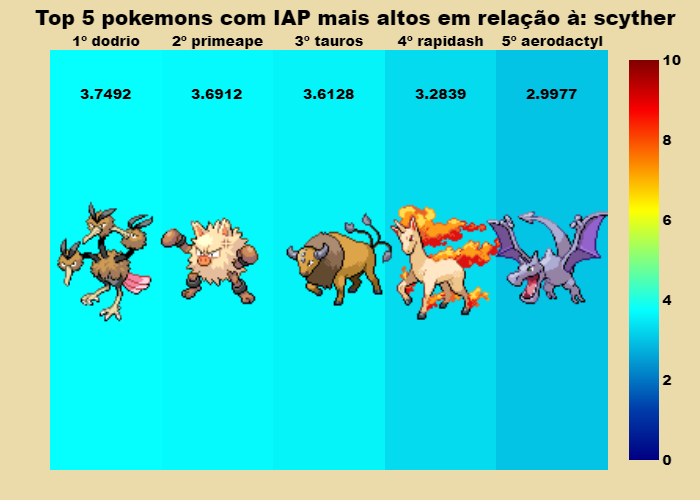

In [8]:
teste1 = find_pokemon_alike("scyther",5)
plot_graphic(teste1[1], teste1[2], teste1[3])

# **CASO CHANSEY**

A **Chansey** é um Pokémon da 1ª geração com os status base mais **'exóticos'** dentre todos. Isso faz com que o Pokémon com maior **Índice de Afinidade Pokémon (IAP)** em relação a ela seja consideravelmente inferior.  

Observe os valores dos vetores de status base de **Chansey** e de **Wigglytuff**:
***
### **CHANSEY**

![img1](imagens/chansey_status.png)

### **WIGGLYTUFF**

![img1](imagens/wigglytuff_status.png)

Veja abaixo o gráfico:


In [ ]:
ranking=5

most_excentric = acha_mais_distante(ranking)
most_excentric_dist = find_pokemon_alike(most_excentric,ranking)

plot_graphic(most_excentric_dist[1], most_excentric_dist[2], most_excentric_dist[3])

# **CASO POLIWAG**

O **Poliwag** é um Pokémon da 1ª geração com os status base mais **'genéricos'** dentre todos. Isso faz com que hajam Pokémons com **Índice de Afinidade Pokémon (IAP)** em relação a ela seja consideravelmente mais altoo, tendo, inclusive, o **Meowth** com IAP quase perfeito em torno de **12%** de afinidade (IAP acima de 10% já considera-se práticamente idêntico). 

Observe os valores dos vetores de status base de **Poliwag** e de **Meowth**:
***
### **POLIWAG**

![img1](imagens/poliwag_status.png)

### **MEOWTH**

![img1](imagens/meowth_status.png)

Veja abaixo o gráfico:


In [ ]:
ranking=5

most_generic = acha_mais_próximo(ranking)
most_generic_dist = find_pokemon_alike(most_generic, ranking)

plot_graphic(most_generic_dist[1], most_generic_dist[2], most_generic_dist[3])

# **DEMAIS CASOS**

***

Plotamos outros casos para exemplificar e elucidar em caráter especial os pokémons ***DITTO** e **MEW**, que possuem todos os status iguais.

- **Ditto** possui todos os seus status base iguais à: $\begin{bmatrix} 48 \\ 48 \\ 48 \\ 48 \\ 48 \\ 48\end{bmatrix} $, e o pokémon com maior IAP em relação a ele é a **Nidoran-Fêmea**, que possui o vetor: $\begin{bmatrix} 55 \\ 47 \\ 52 \\ 40 \\ 40 \\ 41\end{bmatrix} $. 

**Mew** é um pokémon **lendário** que possui todos os seus status base iguais: $\begin{bmatrix} 100 \\ 100 \\ 100 \\ 100 \\ 100 \\ 100\end{bmatrix} $, e o pokémon com maior IAP é a **Arcanine**, que possui o vetor: $\begin{bmatrix} 90 \\ 110 \\ 80 \\ 100 \\ 80 \\ 95\end{bmatrix} $.

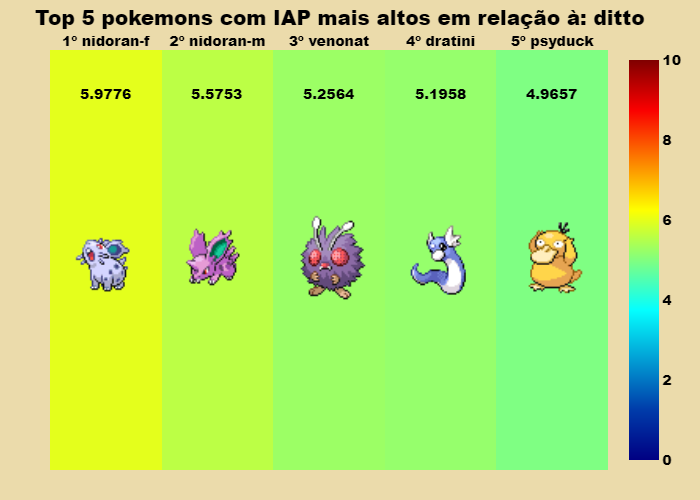

In [9]:
ditto = find_pokemon_alike("ditto",5)
plot_graphic(ditto[1],ditto[2],ditto[3])

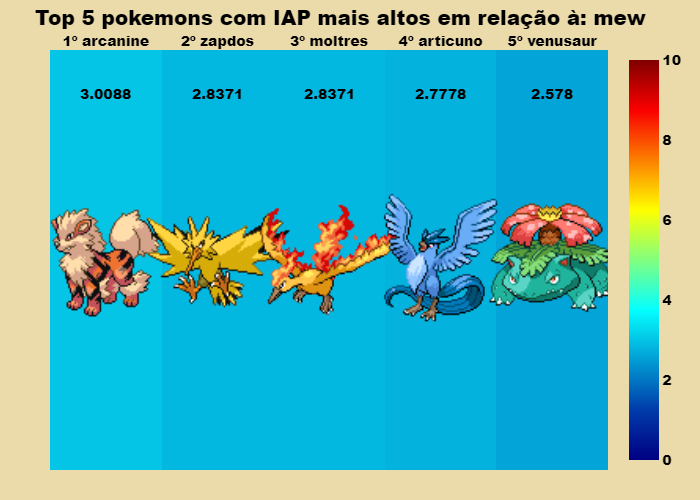

In [10]:
mew = find_pokemon_alike("mew",5)
plot_graphic(mew[1],mew[2],mew[3])

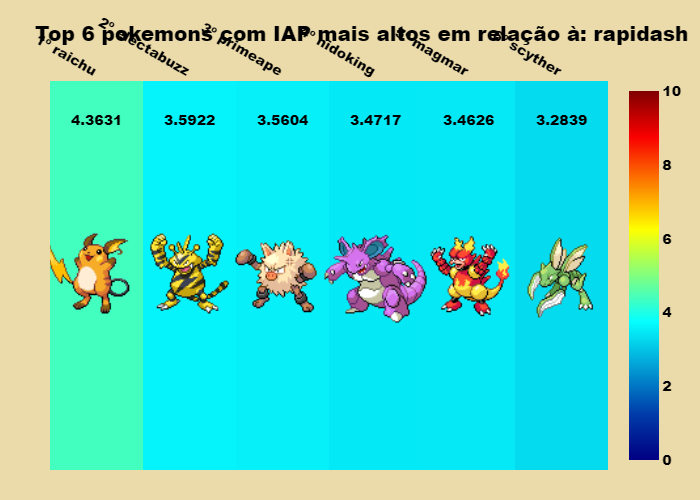

In [11]:
teste2 = find_pokemon_alike("rapidash",6)
plot_graphic(teste2[1], teste2[2], teste2[3])

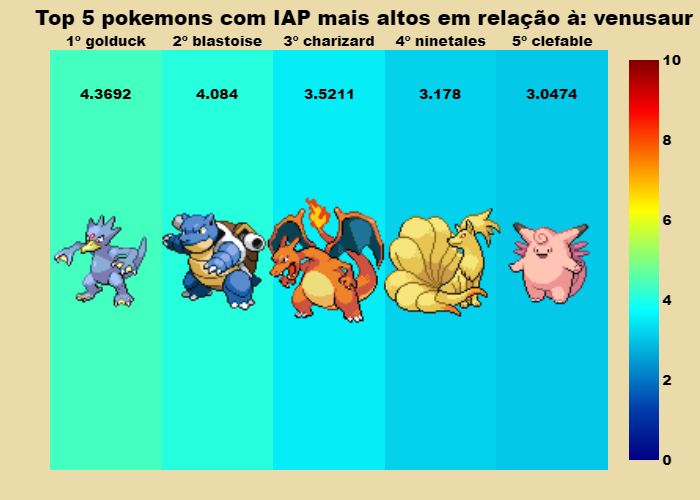

In [12]:
teste3 = find_pokemon_alike("venusaur",5)
plot_graphic(teste3[1], teste3[2],teste3[3])